# Augmentations of EEG-signals

In [4]:
import torch
import numpy as np
from datasets.augmentations import *
from datasets.SHHS_dataset_timeonly import SHHS_dataset_1
import matplotlib.pyplot as plt
import os
print(os.getcwd())

C:\Users\tomsm\PycharmProjects\thesis\datasets


In [5]:
# A function for plotting
def plot_augmentation(x, x_aug):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.plot(x.squeeze(), linewidth=1.0, label="Original eeg-signal")
    plt.plot(x_aug.squeeze(), linewidth=1.0, label="Augmented eeg-signal")
    plt.legend(loc="upper left")

## DC-shift

In [6]:
ds = SHHS_dataset_1('../../thesis01/data/', 1, 2)
x = ds.__getitem__(1)[0]
x_prev = ds.__getitem__(0)[0]
dc = DCShift(mini=1,
             maxi=5,
             prob=1,
             batch_size=1)
x_dc = dc(x, x_prev)

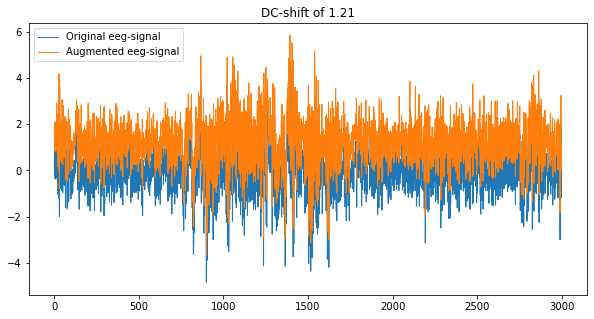

In [7]:
plot_augmentation(x, x_dc)
plt.title(f"DC-shift of {dc.u.item():.2f}")
plt.show()

## Amplitude scale

Text(0.5, 1.0, 'Amplitude shift of 0.71')

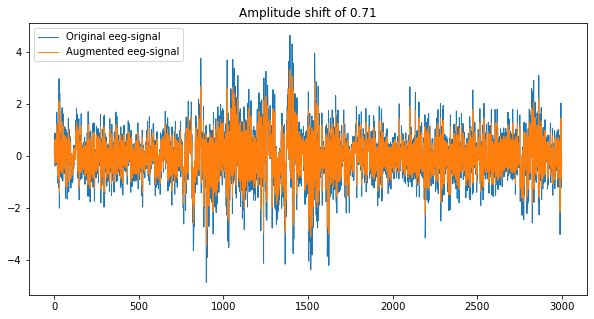

In [8]:
am = AmplitudeScale(mini=0.5,
                    maxi=0.75,
                    prob=1,
                    batch_size=1)
x_am = am(x, x_prev)
plot_augmentation(x, x_am)
plt.title(f"Amplitude shift of {am.u.item():.2f}")

## Time shift

Text(0.5, 1.0, 'Time shift of 268')

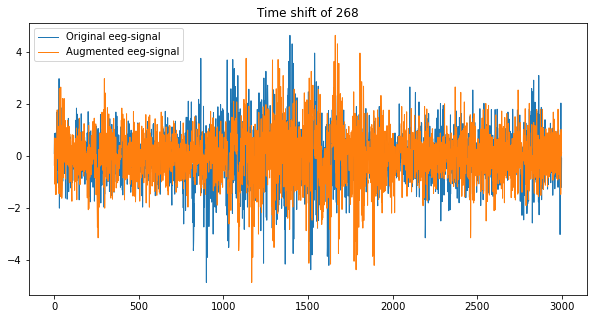

In [9]:
ts = TimeShift(mini=200,
               maxi=400,
               prob=1,
               batch_size=1)
x_ts = ts(x, x_prev)
plot_augmentation(x, x_ts)
plt.title(f"Time shift of {int(ts.u.item())}")

In [10]:
print(x_ts.squeeze()[1])
print(x_prev.squeeze()[-220])

tensor(0.6981)
tensor(0.9840)


## Zero Mask

Text(0.5, 1.0, 'Zero mask of 583')

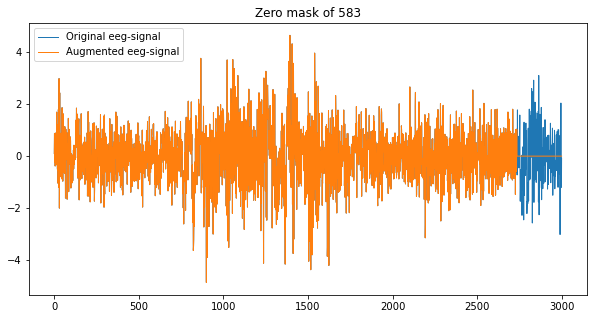

In [11]:
zm = ZeroMask(mini=400,
              maxi=600,
              prob=1,
              batch_size=1)
x_zm = zm(x, x_prev)
plot_augmentation(x, x_zm)
plt.title(f"Zero mask of {int(zm.u.item())}")

## Gaussian noise

Text(0.5, 1.0, 'Additive gaussian noise of stdev: 0.60')

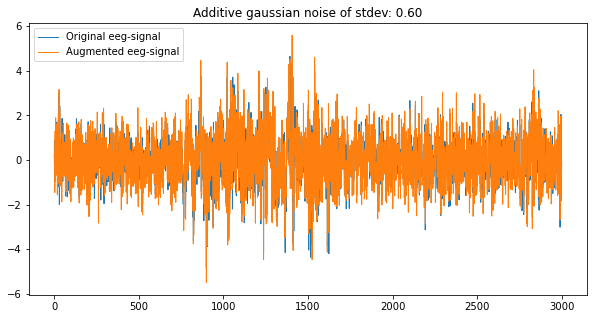

In [12]:
gn = GaussianNoise(mini=0.4,
                   maxi=0.6,
                   prob=1,
                   batch_size=1)
x_gn = gn(x, x_prev)
plot_augmentation(x, x_gn)
plt.title(f"Additive gaussian noise of stdev: {gn.u.item():.2f}")

## Band stop filter: TODO

## Composition of multiple transforms

Text(0.5, 1.0, 'Two different augmentations of the same signal')

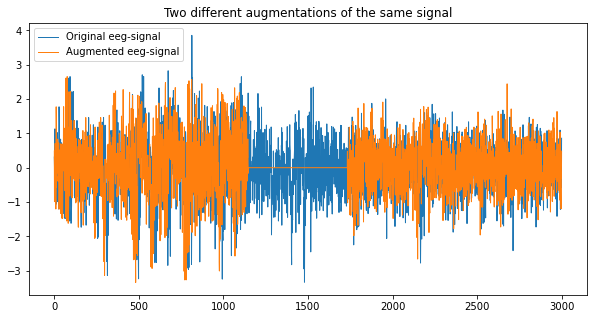

In [13]:
contrast_transforms = ContrastiveTransformations(
    [
        am,
        gn,
        zm,
        ts
    ], n_views=2
)
ds_augmented = SHHS_dataset_1('../../thesis01/data/', 1, 2, transform=contrast_transforms)
x_aug = ds_augmented.__getitem__(0)[0]
plot_augmentation(*x_aug)
plt.title("Two different augmentations of the same signal")

In [15]:
x_aug

[tensor([[[ 0.3093,  0.0540, -0.8174,  ..., -0.5839,  0.2224,  0.8573]]]),
 tensor([[[ 0.4874, -0.9899, -0.1848,  ..., -0.1686, -0.2944,  0.4824]]])]

Let's try to stack 3 couples of augmented images (thus 6 images) into a single tensor

In [14]:
inputs = [ds_augmented.__getitem__(i)[0] for i in range(3)]
print(inputs[0].shape)
inputs = torch.stack(inputs, dim=0)
print(inputs.shape)


AttributeError: 'list' object has no attribute 'shape'